In [1]:
import pyarrow.parquet as pq
import pandas as pd
import ahocorasick
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt
import re
import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
tqdm.pandas()

In [2]:
parq_file = "/home1/wangd/project/PXD016999/PXD016999-first-instrument-8b005cd8-d641-4d1e-a085-c92ed045b4da.psm.parquet"
table = pq.read_table(parq_file)
original_df1 = table.to_pandas()

parq_file = "/home1/wangd/project/PXD016999/PXD016999-second-instrument-2739df94-8ceb-4033-a8d3-91adba121f3f.psm.parquet"
table = pq.read_table(parq_file)
original_df2 = table.to_pandas()

original_df = pd.concat([original_df1, original_df2], axis=0)

In [3]:
print('Number of PSMs in the file = ', len(original_df))

Number of PSMs in the file =  7239144


In [4]:
#Convert array values in the accession to list
def join_vals(x):
    return ','.join(x.astype(str).tolist())

original_df['protein_accessions'] = original_df['protein_accessions'].apply(join_vals)
original_df

,sequence,protein_accessions,protein_start_positions,protein_end_positions,protein_global_qvalue,unique,modifications,retention_time,charge,exp_mass_to_charge,...,is_decoy,id_scores,consensus_support,reference_file_name,scan_number,mz_array,intensity_array,num_peaks,gene_accessions,gene_names
0,DSYVGDEAQSK,"GCA_11383,GCA_11384,GCA_11385,GCA_215568,GCA_2...","[8, 53, 53, 51, 51, 51, 51, 53, 53, 52, 52, 52...","[18, 63, 63, 61, 61, 61, 61, 63, 63, 62, 62, 6...",NaN,0,[0|11-UNIMOD:737],11.018846,3,552.953308,...,0,"['OpenMS:Target-decoy PSM q-value':0.0, Best P...",1.0,Instrument1_sample01_121115_Fr03,37,None,None,NaN,None,None
1,QEYDEAGPSIVHR,"GCA_11383,GCA_11384,GCA_11385,GCA_31297,GCA_42...","[317, 362, 336, 362, 362, 362, 362, 317, 362, ...","[329, 374, 348, 374, 374, 374, 374, 329, 374, ...",NaN,0,[0-UNIMOD:737],15.146831,3,577.294373,...,0,"['OpenMS:Target-decoy PSM q-value':0.0, Best P...",1.0,Instrument1_sample01_121115_Fr03,55,None,None,NaN,None,None
2,DSDMGSRPESMGCR,"GCA_104542,GCA_104543,GCA_120051,GCA_124776,GC...","[1823, 279, 1823, 1823, 279, 1823, 279, 1, 182...","[1836, 292, 1836, 1836, 292, 1836, 292, 14, 18...",NaN,0,"[0-UNIMOD:737, 4|11-UNIMOD:35, 13-UNIMOD:4]",264.042270,3,615.927490,...,0,['OpenMS:Target-decoy PSM q-value':0.002957931...,1.0,Instrument1_sample01_121115_Fr03,1145,None,None,NaN,None,None
3,SHEAQVQEMR,"GCA_100434,GCA_100435,GCA_100436,GCA_100437,GC...","[1189, 1196, 1196, 1189, 1189, 1196, 1196, 118...","[1198, 1205, 1205, 1198, 1198, 1205, 1205, 119...",NaN,0,"[0-UNIMOD:737, 9-UNIMOD:35]",272.818940,3,487.242310,...,0,"['OpenMS:Target-decoy PSM q-value':0.0, Best P...",1.0,Instrument1_sample01_121115_Fr03,1192,None,None,NaN,None,None
4,VPENTMHAMQQK,"GCA_116384,GCA_137052,GCA_137053,GCA_137054,GC...","[301, 301, 261, 301, 236, 236, 301, 301, 301, ...","[312, 312, 272, 312, 247, 247, 312, 312, 312, ...",NaN,0,"[6|9-UNIMOD:35, 12-UNIMOD:737]",275.908330,3,558.940979,...,0,['OpenMS:Target-decoy PSM q-value':0.001260600...,1.0,Instrument1_sample01_121115_Fr03,1208,None,None,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3708333,TCVADESAENCDK,"CONTAMINANT_P02768-1,CONTAMINANT_sp|ALBU_HUMAN...","[76, 76, 76, 76, 78, 76, 76, 76, 76, 78, 76, 7...","[88, 88, 88, 88, 90, 88, 88, 88, 88, 90, 88, 8...",NaN,0,"[0|13-UNIMOD:737, 2|11-UNIMOD:4]",10679.900000,3,652.972717,...,0,"['OpenMS:Target-decoy PSM q-value':0.0, Best P...",1.0,SecondInstrument_Sample18_S2R20_040416_Fr02,67299,None,None,NaN,None,None
3708334,ETYGEMADCCAK,"CONTAMINANT_P02768-1,CONTAMINANT_sp|ALBU_HUMAN...","[106, 106, 106, 106, 108, 106, 106, 106, 106, ...","[117, 117, 117, 117, 119, 117, 117, 117, 117, ...",NaN,0,"[0|12-UNIMOD:737, 6-UNIMOD:35, 9|10-UNIMOD:4]",10705.300000,3,636.955932,...,0,"['OpenMS:Target-decoy PSM q-value':0.0, Best P...",1.0,SecondInstrument_Sample18_S2R20_040416_Fr02,67435,None,None,NaN,None,None
3708335,TCVADESAENCDK,"CONTAMINANT_P02768-1,CONTAMINANT_sp|ALBU_HUMAN...","[76, 76, 76, 76, 78, 76, 76, 76, 76, 78, 76, 7...","[88, 88, 88, 88, 90, 88, 88, 88, 88, 90, 88, 8...",NaN,0,"[0|13-UNIMOD:737, 2|11-UNIMOD:4]",10760.000000,3,652.972961,...,0,"['OpenMS:Target-decoy PSM q-value':0.0, Best P...",1.0,SecondInstrument_Sample18_S2R20_040416_Fr02,67731,None,None,NaN,None,None
3708336,TCVADESAENCDK,"CONTAMINANT_P02768-1,CONTAMINANT_sp|ALBU_HUMAN...","[76, 76, 76, 76, 78, 76, 76, 76, 76, 78, 76, 7...","[88, 88, 88, 88, 90, 88, 88, 88, 88, 90, 88, 8...",NaN,0,"[0|13-UNIMOD:737, 2|11-UNIMOD:4]",10760.900000,3,652.972533,...,0,"['OpenMS:Target-decoy PSM q-value':0.0, Best P...",1.0,SecondInstrument_Sample18_S2R20_040416_Fr02,67735,None,None,NaN,None,None


#### Blast GCA with canonical

In this step, we need to take all the PSMs from the search and blast them against canonical databases including ENSEMBL protein database and Uniprot proteomes. This step is important because some non-canonical peptides may be identified in the GCA proteins but they also are found in reference databases. 


In [5]:
fa_set = set()
for j in SeqIO.parse("/home1/wangd/project/can_db/Homo_sapiens.GRCh38.pep.all.fa", "fasta"):
    fa_set.add(str(j.seq))
for j in SeqIO.parse("/home1/wangd/project/can_db/UP000005640_9606_additional.fasta", "fasta"):
    fa_set.add(str(j.seq))

In [6]:
def blast_with_canonical_fasta(peptide):
    for fasta in fa_set:
        if peptide in fasta:
            return "GRCh38"
    return "GCA"

In [7]:
start_time = datetime.datetime.now()
print(start_time)

seq_set = set(original_df["sequence"].to_list())

auto = ahocorasick.Automaton()
seq_dict = dict()
for seq_peptide in seq_set:
    auto.add_word(seq_peptide, seq_peptide)
    seq_dict[seq_peptide] = "GCA"

auto.make_automaton()

for protein_seq in tqdm(fa_set):
    for end_ind, found in auto.iter(protein_seq):
        seq_dict[found]= "GRCh38"

end_time = datetime.datetime.now()
print("End time :", end_time)
set_time_taken = end_time - start_time
print("Time consumption :", set_time_taken)

print("GCA: {}".format(sum(1 for v in seq_dict.values() if v == "GCA")))
print("GRCh38: {}".format(sum(1 for v in seq_dict.values() if v == "GRCh38")))

2024-04-13 12:42:25.703188


100%|██████████| 104157/104157 [00:04<00:00, 22944.27it/s]

End time : 2024-04-13 12:42:31.518435
Time consumption : 0:00:05.815247
GCA: 39545
GRCh38: 245785


In [8]:
#shorten accessions to save memory
def get_source(accessions):
    accessions = accessions.split(',')

    for acc in accessions:
        if acc.startswith('DECOY_CONTAMINANT'):
            return 'DECOY_CONTAMINANT'
    for acc in accessions:
        if acc.startswith('CONTAMINANT'):
            return 'CONTAMINANT'
    
    for acc in accessions:
        if acc.startswith('DECOY_GRCh38'):
            return 'DECOY_GRCh38'
    
    for acc in accessions:
        if acc.startswith('DECOY_GCA'):
            return 'DECOY_GCA'

    for acc in accessions:
        if acc.startswith('GRCh38'):
            return 'GRCh38'
    
    for acc in accessions:
        if acc.startswith('GCA'):
            return 'GCA'
    
    return accessions

In [9]:
original_df['prot_source'] = original_df['protein_accessions'].progress_apply(get_source)

100%|██████████| 7239144/7239144 [01:38<00:00, 73336.09it/s]


In [10]:
original_df['prot_source'] = original_df.progress_apply(lambda x: seq_dict.get(x['sequence']) if x['prot_source'] == 'GCA' else x['prot_source'], axis=1)

100%|██████████| 7239144/7239144 [00:55<00:00, 131395.16it/s]


In [11]:
original_df['prot_source'].value_counts()

GRCh38               6629473
CONTAMINANT           476829
DECOY_GRCh38           69624
GCA                    55569
DECOY_GCA               6513
DECOY_CONTAMINANT       1136
Name: prot_source, dtype: int64

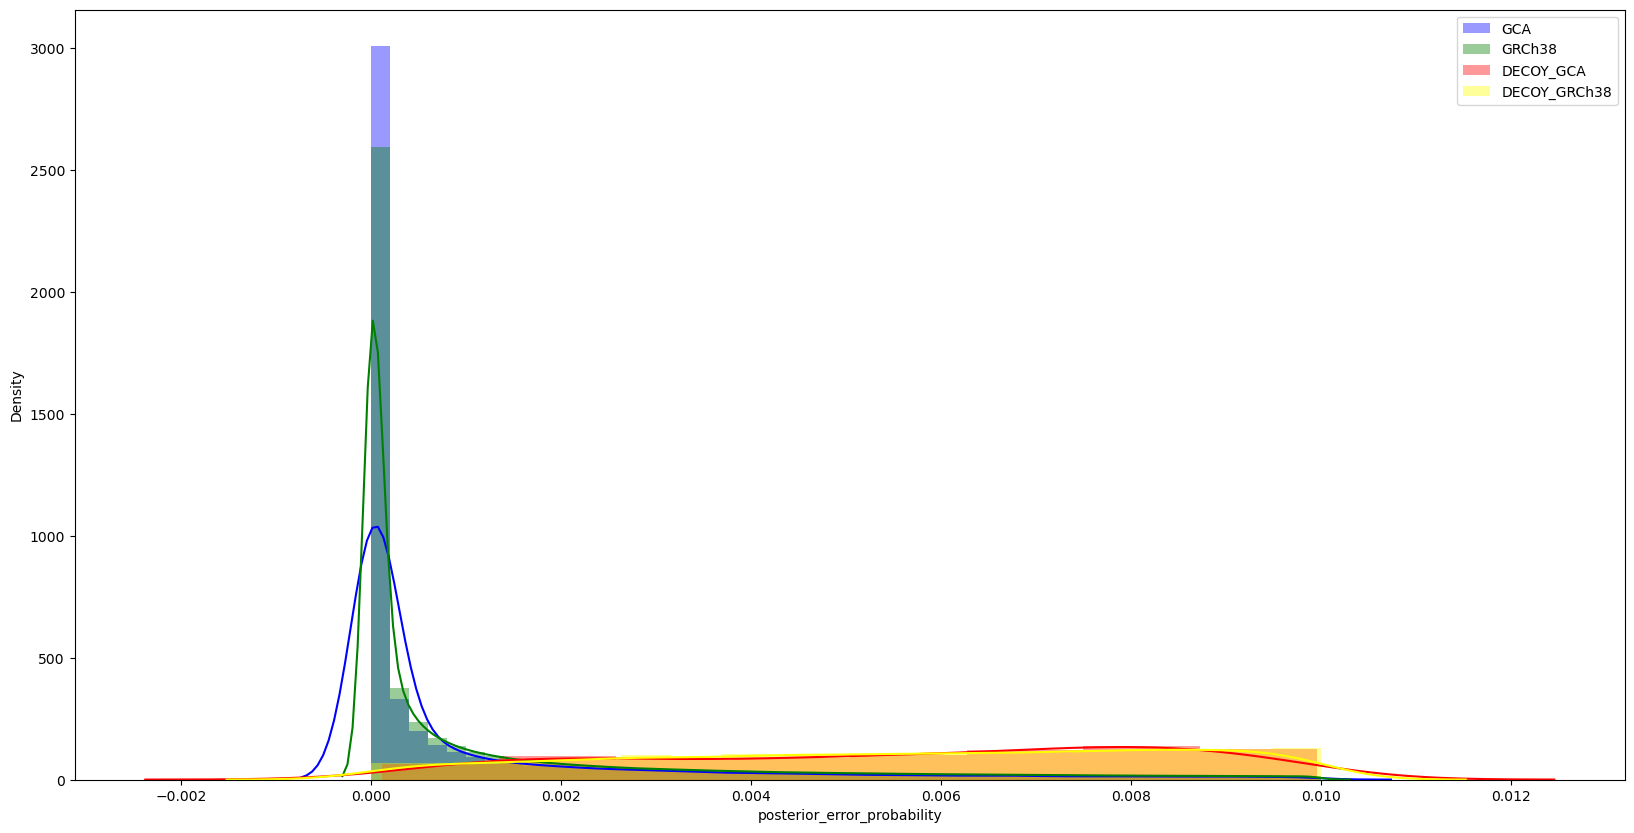

In [12]:
df2 = original_df[original_df['posterior_error_probability']<0.01]

gca = df2.loc[df2.prot_source.str.startswith("GCA")==True]
grch = df2.loc[df2.prot_source.str.startswith("GRCh38")==True]
decoy_grch = df2.loc[df2.prot_source.str.startswith("DECOY_GRCh38")==True]
decoy_gca = df2.loc[df2.prot_source.str.startswith("DECOY_GCA")==True]

#sns.df['posterior_error_probability']

plt.figure(figsize=(20, 10))
sns.distplot(gca['posterior_error_probability'], 
             hist=True, kde=True, label='GCA', color='blue')
sns.distplot(grch['posterior_error_probability'], 
             hist=True, kde=True, label='GRCh38', color='green')
sns.distplot(decoy_gca['posterior_error_probability'], 
             hist=True, kde=True, label='DECOY_GCA', color='red')
sns.distplot(decoy_grch['posterior_error_probability'], 
             hist=True, kde=True, label='DECOY_GRCh38', color='yellow')

plt.legend()

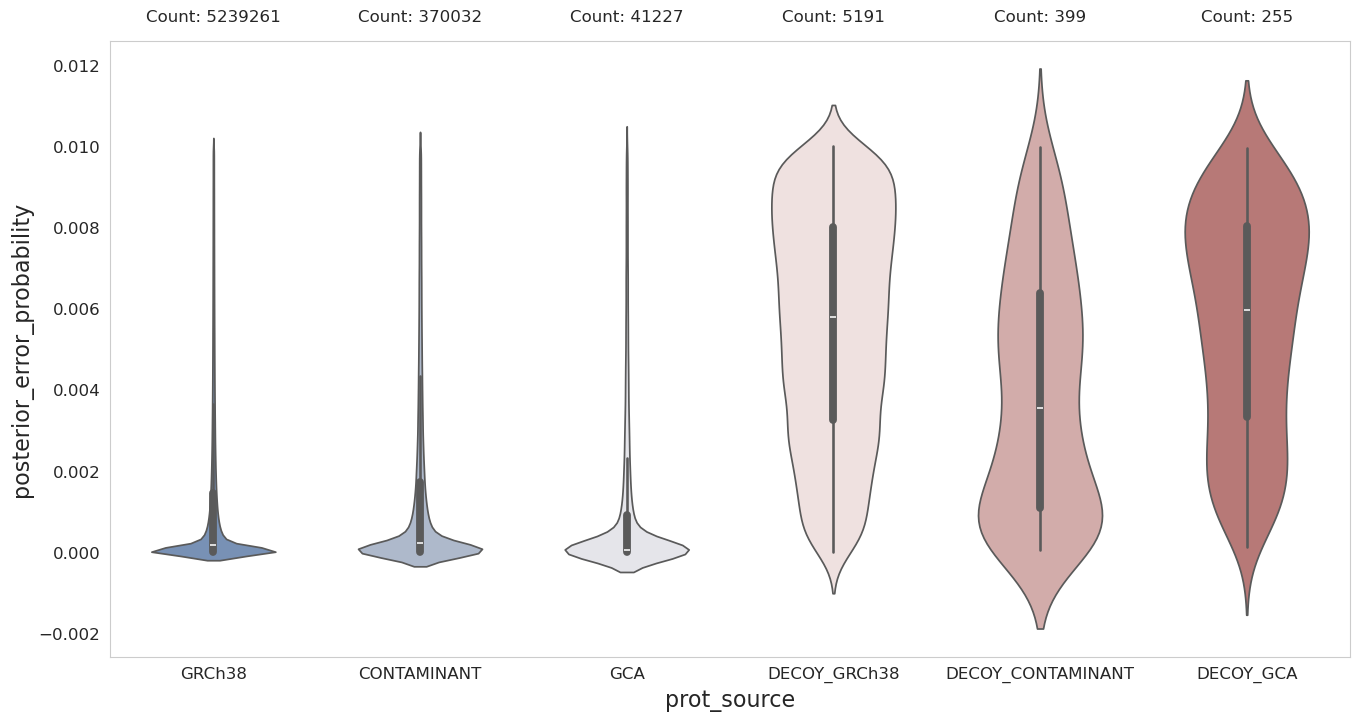

In [13]:
plt.figure(figsize=(16, 8))

sns.set_style("whitegrid")

sns.violinplot(
    data=df2, x="prot_source", y="posterior_error_probability", fill="prot_source",
    width=.6, palette="vlag"
)

count_data = df2["prot_source"].value_counts()
for idx, count in enumerate(count_data):
    plt.text(idx, df2["posterior_error_probability"].max() + 0.003, f'Count: {count}', 
             ha='center', va='bottom', fontsize=12) 

plt.xticks(rotation=0, fontsize=12)  
plt.xlabel("prot_source", fontsize=16)  
plt.ylabel("posterior_error_probability", fontsize=16)  
plt.yticks(fontsize=14)  
plt.tick_params(axis='both', which='both', labelsize=12) 
plt.grid(False) 
# plt.savefig("pep_violin_distributions.svg", format="svg")
plt.show()

In [14]:
original_df[original_df['posterior_error_probability']<0.01]['prot_source'].value_counts()

GRCh38               5239261
CONTAMINANT           370032
GCA                    41227
DECOY_GRCh38            5191
DECOY_GCA                399
DECOY_CONTAMINANT        255
Name: prot_source, dtype: int64

In [15]:
print('Number of unique peptide sequences from\n GCA: {}\n canonical: {}'.format(len(gca.sequence.unique()), len(grch.sequence.unique())))
print('union', len(set(grch.sequence).union(set(gca.sequence))))
print('intesect', len(set(grch.sequence).intersection(set(gca.sequence))))

Number of unique peptide sequences from
 GCA: 2706
 canonical: 184690
union 187396
intesect 0


In [16]:
def rep(x):
    return re.sub('{[^}]*}', '', x.replace('(','{').replace(')', '}').replace('.',''))

gca_seqs = list(set([rep(x) for x in gca['sequence'].tolist()]))

len(gca_seqs)

2706

In [17]:
mods_df = gca['modifications'].apply(lambda x: x.tolist() if x is not None else "")

mod_set = set()
for mods in mods_df.to_list():
    for mod in mods:
        mod_set.add(mod.split("-")[-1])
        
mod_set

{'UNIMOD:1', 'UNIMOD:35', 'UNIMOD:4', 'UNIMOD:737'}

#### To DeepLC

In [18]:
mod_rep = {"UNIMOD:4":"Carbamidomethyl","UNIMOD:737":"TMT6plex","UNIMOD:35":"Oxidation","UNIMOD:1":"Acetyl"}
def replace_mod(x):
    s = ""
    for mod in x:
        nums = mod.split("-")[0]
        m = mod.split("-")[1]
        for n in nums.split("|"):
            if s:
                s += "|"
            s += n + "|" + mod_rep.get(m)
    return s

# convert modifications and add the rt and sequence fields
gca.loc[:,"seq"] = gca.apply(lambda x : x["sequence"],axis = 1)
gca.loc[:,"modifications"] = gca.apply(lambda x : replace_mod(x["modifications"]) if x["modifications"] is not None else "", axis = 1)
gca.loc[:,"tr"] = gca.apply(lambda x : x["retention_time"],axis = 1)

grch.loc[:,"seq"] = grch.apply(lambda x : x["sequence"],axis = 1)
grch.loc[:,"modifications"] = grch.apply(lambda x : replace_mod(x["modifications"]) if x["modifications"] is not None else "", axis = 1)
grch.loc[:,"tr"] = grch.apply(lambda x : x["retention_time"],axis = 1)

In [19]:
# grch[['sequence','modifications','retention_time']].to_csv('all_grch_peptides_for_deeplc.csv', index=False)

#### Redundancy removal

In [20]:
def extract_keys_values(id_scores):
    # Split each pair by colon and create a dictionary
    key_value_dict = {}
    for kv in id_scores:
       if kv is None:
          print("The score is None")
       else:
          score_string = kv.split(":")
          if len(score_string) == 2:
            key_value_dict[score_string[0]] = score_string[1]
          elif len(score_string) > 2:
            key_value_dict[":".join(score_string[:-1])] = score_string[-1]
          else:
            print.warning("The score is not in the right format score: value")
    return pd.Series(key_value_dict)  

In [21]:
new_columns = grch.progress_apply(lambda x: extract_keys_values(x["id_scores"]), axis=1)

# Concatenate the new columns with the original DataFrame
grch_deeplc = pd.concat([grch[['seq', 'tr', 'modifications', 'reference_file_name','sequence','protein_accessions','charge','scan_number','peptidoform']], new_columns], axis=1)

100%|██████████| 5239261/5239261 [20:14<00:00, 4312.51it/s]  


In [22]:
grch_deeplc["Best PSM PEP"] = grch_deeplc["Best PSM PEP"].astype(float)
grch_deeplc.sort_values("Best PSM PEP", inplace=True)

In [23]:
new_columns = gca.progress_apply(lambda x: extract_keys_values(x["id_scores"]), axis=1)

# Concatenate the new columns with the original DataFrame
gca_deeplc = pd.concat([gca[['seq', 'tr', 'modifications', 'reference_file_name','sequence','protein_accessions','charge','scan_number','peptidoform']], new_columns], axis=1)

100%|██████████| 41227/41227 [00:08<00:00, 4635.32it/s]


In [24]:
gca_deeplc["Best PSM PEP"] = gca_deeplc["Best PSM PEP"].astype(float)
gca_deeplc.sort_values("Best PSM PEP", inplace=True)

In [25]:
grch_deeplc = grch_deeplc.drop_duplicates(["seq", "modifications"], keep="first")
gca_deeplc = gca_deeplc.drop_duplicates(["seq", "modifications"], keep="first")

In [26]:
grch_deeplc = grch_deeplc[['seq', 'tr', 'modifications']]

#### PeptideAtlas

In [27]:
column_names = ['PeptideAccession', 'observations', 'best score', 'peptide sequence','']
PeptideAtlas = pd.read_table("/home1/wangd/project/can_db/PeptideAtlasInput_concat.PAidentlist.peptideSummary",header=None,names=column_names)

In [28]:
PeptideAtlas_dict = dict(zip(PeptideAtlas['peptide sequence'], PeptideAtlas['observations']))

In [29]:
def getPeptideAtlasObservations(seq):
    if PeptideAtlas_dict.get(seq):
        return PeptideAtlas_dict.get(seq)
    else:
        return 0

In [30]:
gca_deeplc['PeptideAtlas_observations'] = gca_deeplc['sequence'].apply(getPeptideAtlasObservations)

#### Final save

In [31]:
gca_deeplc.to_csv('gca_peptides_for_deeplc.csv', index=False)
grch_deeplc.to_csv('grch_peptides_for_deeplc.csv', index=False)